## `Initial Setup`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_validate, train_test_split, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
def skim_data(data):
    summary = pd.DataFrame({
                    'column': data.columns.values,
                    'type': data.dtypes.values,
                    'n_unique': data.nunique().values,
                    'n_missing': data.isna().sum(),
                    'min': data.min().values,
                    'max': data.max().values,
                    'sample_unique': [data[col].unique() for col in data.columns]
                })
    return summary

## `Contents`

1. Business Understanding
2. Data Understanding
3. Data Preprocessing
4. Modeling
5. Conclusion
6. Recommendation

## `1. Business Understanding`

### **1.1 Context**

Banyak kota di berbagai wilayah dunia sudah menerapkan sistem bike-sharing sebagai salah satu solusi masalah kepadatan lalu-lintas yaitu kemacetan, dan upaya untuk menurunkan emisi gas karbon yang berasal dari penggunaan kendaraan pribadi. Bike-sharing adalah sistem dimana sepeda disediakan oleh suatu instansi di berbagai titik lokasi dalam satu kota untuk dapat disewa oleh publik dalam jangka waktu tertentu, biasanya hitungan menit hingga jam dalam satu hari dan untuk jarak tempuh pendek. Melalui sistem bike-sharing, masyarakat didorong untuk mengurangi penggunaan kendaraan pribadi dengan beralih ke transportasi ramah lingkungan. Salah satu kota yang menerapkan sistem ini adalah Washington DC, ibukota Amerika Serikat. 

Capital Bikeshare merupakan sistem docked bike-sharing di Washington DC yang dimiliki oleh pemerintah setempat. Docked bike-sharing mempunyai sistem penyimpanan sepeda yang 'terkunci' di lokasi yang sudah ditentukan (disebut juga stasiun). Pengguna yang ingin menyewa sepeda dapat membuka kunci sepeda di stasiun keberangkatan dan memarkir sepeda di stasiun tujuan dengan mengunci kembali sepeda pada tempatnya. Mulai beroperasi pada September 2010 dengan meluncurkan 400 sepeda di 49 stasiun, Capital Bikeshare menjadi sistem bike-sharing terbesar di Amerika Serikat sampai tahun 2013. Motivator LLC merupakan kontraktor yang mengelola operasional Capital Bikeshare, mulai dari suplai ketersediaan sepeda hingga perawatan dan perbaikan sepeda.

### **1.2 Problem Statement**

Salah satu komponen penting yang menentukan kesuksesan bike-sharing adalah keseimbangan antara jumlah sepeda yang tersedia (supply) dengan jumlah pengguna sepeda (demand) pada setiap kondisi. Jika jumlah sepeda lebih sedikit dari kebutuhan, maka sistem dapat kehilangan pengguna atau pelanggan. Sebaliknya, jika jumlah sepeda lebih banyak dari jumlah pengguna, sistem menjadi tidak efisien dan dapat menambah biaya operasional hingga perawatan sepeda yang seharusnya bisa tidak perlu dikeluarkan.

### **1.3 Goals**

Dari permasalahan di atas, dengan mengetahui jumlah pengguna sepeda pada kondisi tertentu akan membantu stakeholder terkait yaitu penyedia sepeda (atau dalam konteks ini adalah kontraktor operasional Capital Bikeshare) dalam menentukan suplai sepeda. Jumlah pengguna sepeda ingin diprediksi seakurat mungkin atau mempunyai nilai error prediksi yang sekecil mungkin agar stakeholder dapat mengalokasikan jumlah sepeda tepat dengan kebutuhan sehingga tidak menghilangkan jumlah pengguna maupun menambahkan biaya operasional yang tidak perlu.

### **1.4 Analytic Approach**

Analisis data dilakukan untuk menemukan pola dan membangun model regresi yang dapat memprediksi jumlah pengguna sepeda berdasarkan kondisi suatu hari. Kita akan melihat apakah penggunaan sepeda dipengaruhi oleh cuaca dan musim, dan jika iya, bagaimana cuaca dan musim mempengaruhi penggunaan sepeda.

### **1.5 Metric Evaluation**

Metrik yang digunakan untuk mengevaluasi model adalah:
* Mean Absolute Error (MAE), atau rerata dari error absolut antara nilai prediksi dengan dengan nilai aktual
* Mean Absolute Percentage Error (MAPE), atau rerata dari persentase error antara nilai prediksi dengan dengan nilai aktual

Untuk MAE dan MAPE, semakin kecil nilainya maka semakin baik performa model karena nilai prediksi semakin mendekati nilai aktualnya. Akan tetapi, MAPE memiliki keterbatasan interpretasi ketika error prediksi lebih besar dari nilai aktualnya karena dengan begitu nilai persentasenya akan lebih besar dari 100%.

## `2. Data Understanding`

* Dataset yang digunakan (akses <a href="https://drive.google.com/file/d/1lSbp2GTSgE8jwvA2K8rlLRZIUTWNNfXe/view?usp=drive_link">disini</a>) merupakan data jumlah pengguna sepeda Capital Bikeshare setiap hari di tahun 2011 dan 2012.
* Setiap baris data merepresentasikan informasi terkait jumlah pengguna sepeda dan kondisi cuaca setiap dalam satu hari.

In [3]:
data = pd.read_csv('../data/processed/train.csv')
skim_data(data)

,column,type,n_unique,n_missing,min,max,sample_unique
dteday,dteday,object,639,0,2011-01-01,2012-09-30,"[2011-01-01, 2011-01-02, 2011-01-03, 2011-01-0..."
month,month,object,12,0,april,september,"[january, february, march, april, may, june, j..."
dayofweek,dayofweek,object,7,0,friday,wednesday,"[saturday, sunday, monday, tuesday, wednesday,..."
hour,hour,int64,24,0,0,23,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
workingday,workingday,bool,2,0,False,True,"[False, True]"
holiday,holiday,bool,2,0,False,True,"[False, True]"
season,season,object,4,0,fall,winter,"[winter, spring, summer, fall]"
weather,weather,object,3,0,clear,rain_snow,"[clear, cloudy, rain_snow]"
temperature,temperature,float64,479,0,-10.1,41.2,"[4.3, 3.4, 2.7, 2.2, 1.8, 1.7, 1.6, 1.3, 1.9, ..."
humidity,humidity,int64,82,0,19,100,"[82, 86, 89, 91, 93, 94, 96, 98, 99, 95, 80, 8..."


| Columns                                           | Definition                                                   | 
| ------------------------------------------------- | ------------------------------------------------------------ |
| dteday | date (YYYY-MM-DD) |
| month | january to december |
| dayofweek | monday to sunday |
| hour | hour (0 to 23) |
| workingday | False: not working day <br>True: working day |
| holiday | False: not holiday <br>True: holiday |
| season | winter, spring, summer, fall |
| weather | clear, cloudy, rain_snow |
| temperature | air temperature (°C) at 2 meters above ground |
| humidity | relative humidity (%) at 2 meters above ground |
| count | count of total rental bikes |

In [4]:
display(data[data.duplicated()])
display(data[data.duplicated(subset=['dteday', 'hour'])])

,dteday,month,dayofweek,hour,workingday,holiday,season,weather,temperature,humidity,count


,dteday,month,dayofweek,hour,workingday,holiday,season,weather,temperature,humidity,count


__Insight:__
* Dataset terdiri dari 11 kolom dan 15366 baris
* Variabel **numerical, continuous**:
    * humidity
    * temperature
    * count
* Variabel **categorical**:
    * month
    * dayofweek
    * weather
    * holiday
    * season
    * hour
* Variabel **date**: 
    * dteday
* Dataset lengkap (630 hari x 24 jam = 15536 baris data), tidak terdapat duplikasi maupun missing values. Data siap digunakan untuk melakukan pemodelan forecasting jumlah pengguna Capital Bikeshare per jamnya.
* Variabel count merupakan variabel respon, dependen, atau target dalam pemodelan yang akan diprediksi. Variabel selain itu merupakan variabel independen.
* Encoding perlu dilakukan untuk variabel kategori sesuai dengan jenis model yang akan dipakai.
* Scaling akan dilakukan untuk variabel independen yang bersifat numerik dan kontinu yaitu humidity dan temperature jika diperlukan.

## `3. Modelling`

Alur tahapan modeling yang dilakukan adalah sebagai berikut: benchmark model berbasis decision tree dan linear regression (termasuk feature engineering) dan tuning model terpilih.

### **3.1 Benchmark Model**

#### **3.1.1 Split Train, Test**

Pembagian data train dan test dilakukan menggunakan train_test_split tanpa melakukan pengacakan data (agar data tetap terurut secara waktu). Skema pembagian data train dan test adalah:
* data train merupakan data jumlah pengguna Capital Bikeshare dari bulan Januari 2011 sampai bulan Juni 2012 sebanyak 13128 baris data,
* data test merupakan data jumlah pengguna Capital Bikeshare dari bulan Juli 2012 hingga bulan September 2012 sebanyak 2208 baris data.

In [5]:
df_train, df_test = train_test_split(data, test_size=24*92, shuffle=False)

print(f"train data: {df_train['dteday'].min()} to {df_train['dteday'].max()} ({len(df_train)} rows)")
print(f"test data: {df_test['dteday'].min()} to {df_test['dteday'].max()} ({len(df_test)} rows)")

X_train = df_train.drop(columns=['dteday', 'count'])
y_train = df_train['count']
display(X_train)

train data: 2011-01-01 to 2012-06-30 (13128 rows)
test data: 2012-07-01 to 2012-09-30 (2208 rows)


,month,dayofweek,hour,workingday,holiday,season,weather,temperature,humidity
0,january,saturday,0,False,False,winter,clear,4.3,82
1,january,saturday,1,False,False,winter,clear,3.4,86
2,january,saturday,2,False,False,winter,clear,2.7,89
3,january,saturday,3,False,False,winter,clear,2.2,91
4,january,saturday,4,False,False,winter,clear,1.8,93
...,...,...,...,...,...,...,...,...,...
13123,june,saturday,19,False,False,summer,clear,36.8,32
13124,june,saturday,20,False,False,summer,clear,37.1,31
13125,june,saturday,21,False,False,summer,clear,37.4,31
13126,june,saturday,22,False,False,summer,rain_snow,33.1,44


Benchmark model kemudian akan dilakukan dengan melakukan cross-validation secara time-series pada data train.

In [6]:
# create 5 fold time-series split with 48 data points (or 2 x 24 hours = 2 days gap) to create more independence between data
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48
)

Ada dua jenis model yang digunakan dalam benchmarking yaitu model berbasis decision tree dan linear regresi.

In [7]:
global RANDOM_STATE
RANDOM_STATE = 12

lasso = Lasso(random_state=RANDOM_STATE)
ridge = Ridge(random_state=RANDOM_STATE)
elastic = ElasticNet(random_state=RANDOM_STATE)
dt = DecisionTreeRegressor(random_state=RANDOM_STATE)
rf = RandomForestRegressor(random_state=RANDOM_STATE)
xgb = XGBRegressor(random_state=RANDOM_STATE)
catb = CatBoostRegressor(random_seed=RANDOM_STATE, verbose=False)

log_lasso = TransformedTargetRegressor(lasso, func=np.log, inverse_func=np.exp)
log_ridge = TransformedTargetRegressor(ridge, func=np.log, inverse_func=np.exp)
log_elastic = TransformedTargetRegressor(elastic, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)
log_catb = TransformedTargetRegressor(catb, func=np.log, inverse_func=np.exp)

Masing-masing jenis model akan mempunyai perlakuan yang berbeda khususnya dalam feature preprocessing yaitu:
* Model berbasis decision tree (decision tree, random forest, extra gradient boosting, catboost)
    * Fitur yang bersifat kategori (month, dayofweek, weather, season, holiday, workingday) akan diencoding secara ordinal agar model bisa membuat aturan splitting berdasarkan urutan tersebut.
    * Tidak perlu ada preprocessing untuk fitur numerik.
    * Seperti yang diketahui, variabel target count bersifat right-skewed dan bisa dilakukan transformasi target (agar distribusinya lebih merata) ketika melakukan pemodelan. Akan tetapi, dari hasil eksperimen ditemukan bahwa performa model lebih buruk ketika melakukan transformasi target.
    * Perlu diingat bahwa model berbasis decision tree merupakan model non-parametrik yang tidak memiliki asumsi data yang digunakan terdistribusi normal sehingga model tetap dapat bekerja dengan baik meskipun variabel target bersifat skewed.
* Model berbasis linear regresi (lasso, ridge, elasticnet)
    * Fitur yang bersifat kategori akan diencoding menggunakan one-hot encoding
    * Fitur numerik (humidity, temperature) diskala berdasarkan nilai minimum dan maksimumnya agar fitur numerik mempunyai skala yang bisa dibandingkan
    * Variabel target ditransformasi menggunakan fungsi logaritmik ketika melakukan pemodelan dan diinverse menggunakan fungsi eksponensial untuk mengukur metrik evaluasi

#### **3.1.2 Encode**

In [8]:
continuous_columns = [
    "temperature",
    "humidity"
]

categorical_columns = [
    "month",
    "dayofweek",
    "weather",
    "season",
    "holiday",
    "workingday",
]

categories = [
    ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"],
    ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"],
    ["clear", "cloudy", "rain_snow"],
    ["winter", "spring", "summer", "fall"],
    [False, True],
    [False, True],
]

ordinal_encoder = OrdinalEncoder(categories=categories)

#### **3.1.3 Choose Benchmark Model with Cross-Validation**

In [9]:
models = [log_lasso, log_ridge, log_elastic, dt, rf, xgb, catb]

train_mean_mae, train_std_mae = [], []
train_mean_mape, train_std_mape = [], []
val_mean_mae, val_std_mae = [], []
val_mean_mape, val_std_mape = [], []
mean_fit_time, std_fit_time = [], []


for i, model in enumerate(models):
    preprocessing = ColumnTransformer(
                        transformers=[
                            ("categorical", ordinal_encoder, categorical_columns),
                        ],
                        remainder="passthrough",
                        verbose_feature_names_out=False
                    )
    if i < 3:
        preprocessing = ColumnTransformer(
                            transformers=[
                                ("categorical", OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop='first'), categorical_columns + ["hour"]),
                                ("scaler", MinMaxScaler(), continuous_columns),
                            ],
                            remainder="passthrough",
                            verbose_feature_names_out=False  
                        )

    estimator = make_pipeline(
                    preprocessing,
                    model
                ).set_output(transform="pandas")

    cv_result = cross_validate(
        estimator,
        X_train,
        y_train,
        cv=ts_cv,
        scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'],
        return_train_score=True
    )

    train_mae = -cv_result['train_neg_mean_absolute_error']
    train_mean_mae.append(train_mae.mean())
    train_std_mae.append(train_mae.std())

    train_mape = -cv_result['train_neg_mean_absolute_percentage_error']
    train_mean_mape.append(train_mape.mean())
    train_std_mape.append(train_mape.std())

    val_mae = -cv_result['test_neg_mean_absolute_error']
    val_mean_mae.append(val_mae.mean())
    val_std_mae.append(val_mae.std())

    val_mape = -cv_result['test_neg_mean_absolute_percentage_error']
    val_mean_mape.append(val_mape.mean())
    val_std_mape.append(val_mape.std())

    fit_time = cv_result['fit_time']
    mean_fit_time.append(fit_time.mean())
    std_fit_time.append(fit_time.std())

pd.DataFrame({
    'model': ['LASSO', 'Ridge', 'ElasticNet', 'Decision Tree', 'Random Forest', 'Extra Gradient Boosting', 'CatBoost'],
    'mean_fit_time': mean_fit_time,
    'std_fit_time': std_fit_time,
    'train_mean_MAE': train_mean_mae,
    'train_std_MAE': train_std_mae,
    'val_mean_MAE': val_mean_mae,
    'val_std_MAE': val_std_mae,
    'train_mean_MAPE': train_mean_mape,
    'train_std_MAPE': train_std_mape,
    'val_mean_MAPE': val_mean_mape,
    'val_std_MAPE': val_std_mape
}).sort_values(by=['val_mean_MAE', 'mean_fit_time'], ascending=True).reset_index(drop=True)

,model,mean_fit_time,std_fit_time,train_mean_MAE,train_std_MAE,val_mean_MAE,val_std_MAE,train_mean_MAPE,train_std_MAPE,val_mean_MAPE,val_std_MAPE
0,Random Forest,2.515186,1.261833,8.424558,2.123285,66.082524,25.155530,0.157546,0.016427,0.510854,0.093876
1,Extra Gradient Boosting,0.257632,0.093230,11.737062,5.598722,67.796696,23.138068,0.311843,0.086655,0.809791,0.231471
2,CatBoost,2.681467,0.289881,16.247077,5.862698,69.047628,23.279534,0.420705,0.074182,0.759477,0.234900
3,Decision Tree,0.035431,0.014936,0.000000,0.000000,73.276234,20.854327,0.000000,0.000000,0.615233,0.163325
4,Ridge,0.043267,0.027192,44.069494,10.716945,87.353835,24.723187,0.683345,0.035768,0.593507,0.074437
5,ElasticNet,0.027578,0.008609,94.143520,21.692589,148.599764,36.375789,3.709607,0.158017,2.490053,0.831532
6,LASSO,0.036799,0.011968,94.143520,21.692589,148.599764,36.375789,3.709607,0.158017,2.490053,0.831532


* Tabel di atas merupakan rangkuman performa model atau rerata metrik evaluasi model saat cross-validation
* Nilai error masih tinggi (MAE > 60 dan MAPE > 70) dan terjadi overfitting untuk semua model, diperlukan feature engineering atau tuning model
* Ridge merupakan model berbasis linear regresi dengan nilai MAE terkecil (87.35) dibandingkan dua model lainnya
* Random Forest (RF) merupakan model berbasis decision tree yang memiliki nilai MAE terkecil (66.08). Akan tetapi, Extra Gradient Boosting (XGB) dapat memberikan performa yang mirip (MAE 67.8) dengan waktu training sekitar 10x lebih cepat. Selain itu, RF juga terlihat lebih overfit terhadap training datanya dibandingkan XGB
* Model Ridge dan Extra Gradient Boosting akan diobservasi lebih lanjut
* Extra Gradient Boosting merupakan model ensemble di mana model weak-learner (base learner, biasanya decision trees) digabungkan menjadi strong-learner (meta-learner) dengan mengoreksi error dari model sebelumnya secara sekuensial (hal ini dapat menurunkan bias performa model). Model ini disebut ekstra karena adanya penambahan tingkat pengacakan dalam pembuatan model decision trees seperti random feature subsampling (baik secara kolom maupun baris) atau random split threshold.
* Ridge merupakan model regresi linier yang menerapkan penalti pada cost function persamaan regresi dengan menambahkan parameter alpha atau lambda sebagai ukuran regularisasi (semakin besar nilai, semakin besar pengaruhnya) dan dapat membantu mencegah overfitting.

#### **3.1.3 Add Time Feature**

* Salah satu fitur waktu yang bisa digunakan dalam pemodelan time-series adalah fitur lag dari variabel target atau nilai variabel target pada periode sebelumnya (untuk kasus ini berarti jumlah pengguna sepeda di jam sebelumnya)
* Kita akan mencari banyaknya lag (berapa jauh periode sebelumnya) yang optimal terhadap performa model melalui iterasi
* Yang akan dilakukan adalah melakukan lag sejumlah urutan iterasi (lag 1 berarti jumlah pengguna di satu jam sebelumnya, lag 2 berarti 2 jam sebelumnya dst) dan menambahkan data tersebut ke fitur yang sudah ada
* Model yang digunakan adalah model dengan performa terbaik di benchmark yaitu Extra Gradient Boosting

In [10]:
mean_rmse, std_rmse = [], []
mean_mae, std_mae = [], []
mean_mape, std_mape = [], []

for lag in np.arange(1,25):
    ts_train, ts_test = train_test_split(data, test_size=24*92, shuffle=False)
    ts_train[f'count_lag_{lag}'] = ts_train['count'].shift(lag, fill_value=-1)

    X_train_ts = ts_train.drop(columns=['dteday', 'count'])
    y_train_ts = ts_train['count']

    # INITIALIZE UNTRAINED MODEL ON EACH ITERATION
    estimator = make_pipeline(
                    ColumnTransformer(
                        transformers=[
                            ("categorical", ordinal_encoder, categorical_columns),
                        ],
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                    ),
                    XGBRegressor(random_state=RANDOM_STATE)
                ).set_output(transform="pandas")
    cv_result = cross_validate(
        estimator,
        X_train_ts,
        y_train_ts,
        cv=ts_cv,
        scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'],
        return_train_score=True
    )

    val_mae = -cv_result['test_neg_mean_absolute_error']
    mean_mae.append(val_mae.mean())
    std_mae.append(val_mae.std())

    val_mape = -cv_result['test_neg_mean_absolute_percentage_error']
    mean_mape.append(val_mape.mean())
    std_mape.append(val_mape.std())

pd.DataFrame({
    'count_lag': np.arange(1,25),
    'mean_MAE': mean_mae,
    'std_MAE': std_mae,
    'mean_MAPE': mean_mape,
    'std_MAPE': std_mape
}).set_index('count_lag')

,mean_MAE,std_MAE,mean_MAPE,std_MAPE
count_lag,,,,
1,36.188775,11.113782,0.383843,0.110368
2,49.528068,11.276599,0.533506,0.158216
3,59.375640,16.695418,0.647933,0.177241
4,63.231253,18.654068,0.704538,0.168853
5,66.038637,18.725827,0.795998,0.243434
6,66.175429,21.102581,0.763708,0.198907
7,68.929638,21.085199,0.832807,0.304185
8,69.454858,18.697478,0.828950,0.308485
9,65.390776,17.449773,0.800747,0.222369


* Variabel lag yang diamati ada sejumlah 24 dengan arti menggunakan data jumlah pengguna sepeda hingga 24 jam atau 1 hari sebelumnya
* Fitur lag yang menghasilkan performa paling baik adalah lag 1 (MAE pada cross-validasi menjadi 36.8 dari sebelumnya 66.08), atau jumlah pengguna sepeda di satu jam sebelumnya dan selanjutnya akan digunakan sebagai fitur tambahan pada pemodelan

#### **3.1.4 Resplit Train, Test with New Feature**

* Setelah menambahkan fitur lag 1 jam atau jumlah pengguna sepeda di jam sebelumnya, data displit ulang menjadi train dan test

In [11]:
data['count_lag_1'] = data['count'].shift(1, fill_value=-1)
features = data.drop(columns=['dteday', 'count'])
target = data['count']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=24*92, shuffle=False)
X_train

,month,dayofweek,hour,workingday,holiday,season,weather,temperature,humidity,count_lag_1
0,january,saturday,0,False,False,winter,clear,4.3,82,-1
1,january,saturday,1,False,False,winter,clear,3.4,86,16
2,january,saturday,2,False,False,winter,clear,2.7,89,40
3,january,saturday,3,False,False,winter,clear,2.2,91,32
4,january,saturday,4,False,False,winter,clear,1.8,93,13
...,...,...,...,...,...,...,...,...,...,...
13123,june,saturday,19,False,False,summer,clear,36.8,32,339
13124,june,saturday,20,False,False,summer,clear,37.1,31,374
13125,june,saturday,21,False,False,summer,clear,37.4,31,292
13126,june,saturday,22,False,False,summer,rain_snow,33.1,44,213


#### **3.1.5 Select Features with Permutation Feature Importance and Forward Selection**

* Feature engineering yang selanjutnya akan dicoba adalah feature selection berdasarkan feature importance dengan permutasi dan forward selection. Tujuannya adalah agar fitur yang digunakan hanya merupakan fitur yang berperan optimal terhadap performa model

In [12]:
from sklearn.inspection import permutation_importance

# INITIALIZE UNTRAINED MODEL
estimator = make_pipeline(
                ColumnTransformer(
                        transformers=[
                            ("categorical", ordinal_encoder, categorical_columns),
                        ],
                        remainder="passthrough",
                        verbose_feature_names_out=False
                    ),
                XGBRegressor(random_state=RANDOM_STATE)
            ).set_output(transform="pandas")
estimator.fit(X_train, y_train)

r = permutation_importance(estimator, X_train, y_train, n_repeats=30, random_state=0, scoring='neg_root_mean_squared_error')
feature_rank = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<20}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")
        feature_rank.append(X_train.columns[i])

count_lag_1         208.536 +/- 1.314
hour                99.491 +/- 0.769
workingday          14.225 +/- 0.378
dayofweek           12.224 +/- 0.285
temperature         10.513 +/- 0.194
month               7.529 +/- 0.245
humidity            6.281 +/- 0.164
weather             1.727 +/- 0.071
season              1.152 +/- 0.041
holiday             0.431 +/- 0.028


* Permutation feature importance bekerja dengan mengukur performa model menggunakan data original, kemudian melakukan pengacakan nilai per fitur dan melihat pengaruhnya terhadap performa model. Perbedaan performa model dengan data original dan setelah pengacakan menunjukkan seberapa besar pengaruh pengacakan suatu fitur terhadap performa model
* Pada permutation feature importance, fitur yang dinilai bersifat lebih penting adalah fitur yang pengaruhnya lebih besar terhadap perubahan metrik evaluasi
* Akan dilakukan iterasi pemodelan menggunakan kombinasi fitur berdasarkan tingkat feature importancenya, untuk melihat kombinasi mana yang memberikan performa optimal atau nilai error terkecil

In [13]:
mean_mae, std_mae = [], []
mean_mape, std_mape = [], []
feature_names = []

preprocessing_tree_fs = make_pipeline(
                            ColumnTransformer(
                                transformers=[
                                    ("categorical", ordinal_encoder, categorical_columns),
                                ],
                                remainder="passthrough",
                                verbose_feature_names_out=False)
                        ).set_output(transform="pandas")
X_train_fs = preprocessing_tree_fs.fit_transform(X_train)

for i in range(len(feature_rank)):
    feature_names.append(feature_rank[:i+1])
    # INITIALIZE UNTRAINED MODEL IN EACH ITERATION
    estimator = make_pipeline(
                    XGBRegressor(random_state=RANDOM_STATE)
                ).set_output(transform="pandas")
    cv_result = cross_validate(
        estimator,
        X_train_fs[feature_rank[:i+1]],
        y_train,
        cv=ts_cv,
        scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'],
        return_train_score=True
    )

    val_mae = -cv_result['test_neg_mean_absolute_error']
    mean_mae.append(val_mae.mean())
    std_mae.append(val_mae.std())

    val_mape = -cv_result['test_neg_mean_absolute_percentage_error']
    mean_mape.append(val_mape.mean())
    std_mape.append(val_mape.std())

pd.DataFrame({
    'features': feature_names,
    'mean_MAE': mean_mae,
    'std_MAE': std_mae,
    'mean_MAPE': mean_mape,
    'std_MAPE': std_mape
})

,features,mean_MAE,std_MAE,mean_MAPE,std_MAPE
0,[count_lag_1],67.959304,15.295779,0.776604,0.089394
1,"[count_lag_1, hour]",37.658974,11.538928,0.352720,0.045980
2,"[count_lag_1, hour, workingday]",32.764397,11.709682,0.292241,0.043632
3,"[count_lag_1, hour, workingday, dayofweek]",31.797732,11.055450,0.286689,0.043758
4,"[count_lag_1, hour, workingday, dayofweek, tem...",32.754813,11.820460,0.325394,0.093581
5,"[count_lag_1, hour, workingday, dayofweek, tem...",34.358371,10.837095,0.348799,0.082176
6,"[count_lag_1, hour, workingday, dayofweek, tem...",35.159182,10.920726,0.345874,0.072168
7,"[count_lag_1, hour, workingday, dayofweek, tem...",35.332530,11.706829,0.334853,0.052045
8,"[count_lag_1, hour, workingday, dayofweek, tem...",35.916748,10.910744,0.357568,0.073699
9,"[count_lag_1, hour, workingday, dayofweek, tem...",35.898388,10.670846,0.376411,0.103188


* Kombinasi fitur count_lag_1, hour, workingday, dan dayofweek terlihat menghasilkan nilai MAE terkecil (31.79), dapat dikatakan bahwa kita cukup menggunakan kombinasi keempat fitur ini untuk melakukan forecasting jumlah pengguna sepeda

In [14]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
forward = SFS(XGBRegressor(random_state=RANDOM_STATE), 
           k_features=4, 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='neg_mean_absolute_error',
           cv=ts_cv)

forward.fit(X_train_fs, y_train)
selected_forward = X_train_fs.columns[list(forward.k_feature_idx_)]
selected_forward

Index(['dayofweek', 'workingday', 'hour', 'count_lag_1'], dtype='object')

#### **3.1.6 Predict Benchmark Model with Feature Engineering on Test Data**

* Selanjutnya, benchmark model Extra Gradient Boosting dengan hasil feature engineering (penambahan dan pemilihan fitur) akan diprediksi pada data test
* Model Ridge juga akan digunakan sebagai pembanding model yang berbasis linear regression

In [15]:
score_mae = []
score_mape = []

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

xgb = XGBRegressor(random_state=RANDOM_STATE)
ridge = TransformedTargetRegressor(Ridge(random_state=RANDOM_STATE), func=np.log, inverse_func=np.exp)
models = [ridge, xgb]

for i, model in enumerate(models):
    preprocessing = ColumnTransformer(
                        transformers=[
                            ("categorical", OrdinalEncoder(categories=[
                                    [False, True],
                                    ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
                                ]), ["workingday", "dayofweek"])
                        ],
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                    )
    if i == 0:
        preprocessing = ColumnTransformer(
                            transformers=[
                                ("categorical", OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop='first'), ["dayofweek", "workingday", "hour"]),
                                ("scaler", MinMaxScaler(), ["count_lag_1"]),
                            ],
                            remainder="passthrough",
                            verbose_feature_names_out=False  
                        )
    estimator = make_pipeline(
                    preprocessing,
                    model
                ).set_output(transform="pandas")

    estimator.fit(X_train[selected_forward], y_train)

    train_pred = estimator.predict(X_train[feature_rank[:4]])
    score_mae.append(mean_absolute_error(y_train, train_pred))
    score_mape.append(mean_absolute_percentage_error(y_train, train_pred))

    test_pred = estimator.predict(X_test[feature_rank[:4]])
    score_mae.append(mean_absolute_error(y_test, test_pred))
    score_mape.append(mean_absolute_percentage_error(y_test, test_pred))

score_before_tuning = pd.DataFrame({'MAE': score_mae, 'MAPE': score_mape}, index=['Ridge train', 'Ridge test', 'XGB train', 'XGB test'])
score_before_tuning

,MAE,MAPE
Ridge train,59.546088,0.659802
Ridge test,177.714701,0.519712
XGB train,16.247437,0.259709
XGB test,32.835613,0.191029


* Extra Gradient Boosting terlihat memiliki performa yang cukup baik dengan feature engineering (nilai MAE 32.83 dan MAPE 19%)
* Performa model Ridge buruk setelah melakukan feature engineering, perlu pendekatan feature engineering yang lain
* Untuk saat ini, model yang tetap dipilih dan dituning lebih lanjut adalah Extra Gradient Boosting

### **3.2 Tune Model**

#### **3.2.1 Hyperparameter Tuning**

Tuning model adalah proses mencari parameter model yang dapat menghasilkan performa model yang optimal. Proses ini akan dilakukan menggunakan GridSearch yang akan menjalankan semua kombinasi hyperparameter. Parameter yang akan dituning adalah:
* max_depth, maksimal kedalaman decision tree (semakin dalam pohon kecenderungan overfitting semakin tinggi)
* learning_rate, besaran step untuk mengupate prediksi pada setiap iterasi (berpengaruh terhadap seberapa cepat model konvergen)
* n_estimators, banyaknya decision tree yang digunakan sebagai base learner
* colsample_bytree, banyaknya fitur yang digunakan dalam setiap decision tree

In [16]:
max_depth = list(np.arange(1, 6))

learning_rate = [0.001, 0.1, 0.2]

# number of base-learners or decision trees
n_estimators = list(np.arange(100, 301, 10))

# number of features used in each trees (% from total columns)
colsample_bytree = [0.75, 1]

In [17]:
# xgb hyperparameter
hyperparam_space_xgb = {
    'xgbregressor__max_depth': max_depth, 
    'xgbregressor__learning_rate': learning_rate,
    'xgbregressor__n_estimators': n_estimators,
    'xgbregressor__colsample_bytree': colsample_bytree
}

from sklearn.model_selection import GridSearchCV
estimator = make_pipeline(
                ColumnTransformer(
                        transformers=[
                            ("categorical", OrdinalEncoder(categories=[
                                    [False, True],
                                    ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
                                ]), ["workingday", "dayofweek"])
                        ],
                        remainder="passthrough",
                        verbose_feature_names_out=False
                ),
                XGBRegressor(random_state=RANDOM_STATE)
            ).set_output(transform="pandas")

gridsearch_xgb = GridSearchCV(
    estimator, 
    param_grid = hyperparam_space_xgb,
    cv = ts_cv, 
    scoring = 'neg_mean_absolute_error',
    refit = 'neg_mean_absolute_error',
    n_jobs = -1,
)
gridsearch_xgb.fit(X_train[feature_rank[:4]], y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=48, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OrdinalEncoder(categories=[[False,
                                                                                                     True],
                                                                                                    ['monday',
                                                                                                     'tuesday',
                                                                                                     'wednesday',
                                                                                                     'thursday',
                                                                                                     'friday',
                                                                                                     'saturday',
                                                                                                     'sunday']]),
                                                                         ['workingday',
                                                                          'dayofweek'])],
                                                          ve...
                                                     random_state=12, ...))]),
             n_jobs=-1,
             param_grid={'xgbregressor__colsample_bytree': [0.75, 1],
                         'xgbregressor__learning_rate': [0.001, 0.1, 0.2],
                         'xgbregressor__max_depth': [1, 2, 3, 4, 5],
                         'xgbregressor__n_estimators': [100, 110, 120, 130, 140,
                                                        150, 160, 170, 180, 190,
                                                        200, 210, 220, 230, 240,
                                                        250, 260, 270, 280, 290,
                                                        300]},
             refit='neg_mean_absolute_error',
             scoring='neg_mean_absolute_error')

In [29]:
print('Extra Gradient Boosting')
print('Best_score:', -gridsearch_xgb.best_score_)
print('Best_params:', gridsearch_xgb.best_params_)

Extra Gradient Boosting
Best_score: 30.302494606455376
Best_params: {'xgbregressor__colsample_bytree': 1, 'xgbregressor__learning_rate': 0.2, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 180}


#### **3.2.2 Predict Tuned Model on Test Data**

In [19]:
# get best estimator
xgb_tuning = gridsearch_xgb.best_estimator_

# fit model
xgb_tuning.fit(X_train[feature_rank[:4]], y_train)

# predict test set
y_pred_xgb_tuning = xgb_tuning.predict(X_test[feature_rank[:4]])

mae_xgb_tuning = mean_absolute_error(y_test, y_pred_xgb_tuning)
mape_xgb_tuning = mean_absolute_percentage_error(y_test, y_pred_xgb_tuning)

score_after_tuning = pd.DataFrame({'MAE': mae_xgb_tuning, 'MAPE': mape_xgb_tuning}, index=['XGB test'])

In [20]:
score_before_tuning.tail(1)

,MAE,MAPE
XGB test,32.835613,0.191029


In [21]:
score_after_tuning

,MAE,MAPE
XGB test,31.915109,0.199118


* Performa model sedikit lebih baik secara MAE (dari 32.8 menjadi 31.9) tetapi sedikit menurun secara MAPE (19.1% menjadi 19.9%)
* Model yang telah dituning akan digunakan sebagai final model

count_lag_1         295.519 +/- 3.703
hour                132.761 +/- 2.479
workingday          19.143 +/- 1.740
dayofweek           10.851 +/- 0.885


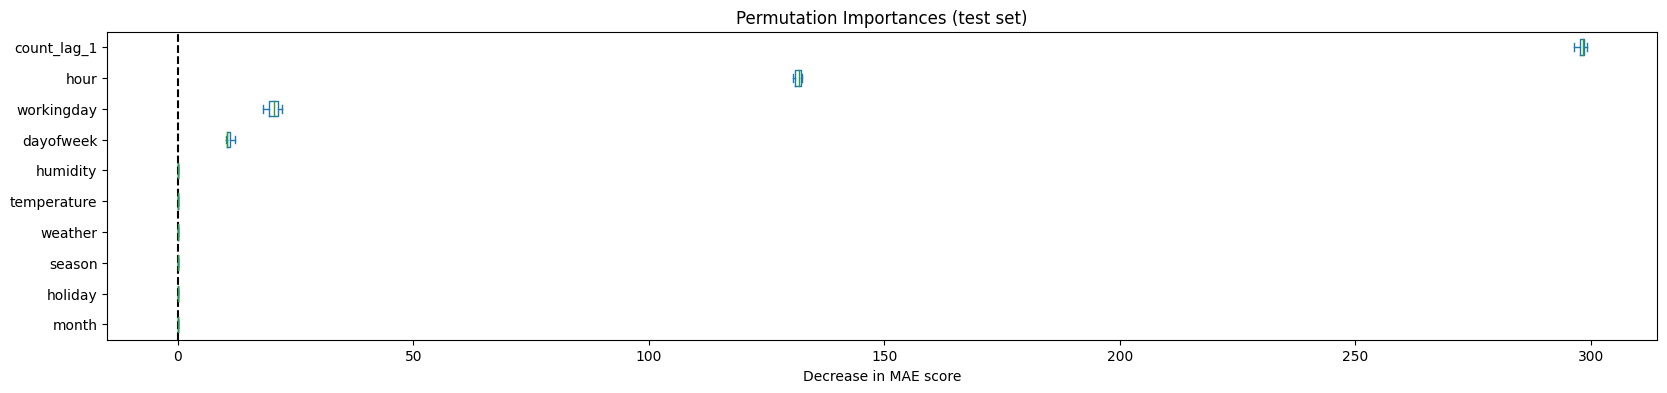

In [22]:
from copy import deepcopy
estimator = deepcopy(xgb_tuning)
r = permutation_importance(estimator, X_test, y_test, n_repeats=30, random_state=0, scoring='neg_root_mean_squared_error')
feature_rank = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<20}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")
        feature_rank.append(X_train.columns[i])

sorted_importances_idx = r.importances_mean.argsort()
importances = pd.DataFrame(
    r.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
ax = importances[:4].plot.box(vert=False, whis=10, figsize=(20,4))
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in MAE score");

* Sebenarnya karena kita telah melakukan feature selection sebelumnya yang juga mempertimbangkan permutation feature importance pada data train, fitur-fitur yang berpengaruh pada model dan prediksi di data test akan tetap sama
* Ketika kita melihat permutation feature importance pada data test, jumlah pengguna sepeda di jam sebelumnya tetap merupakan variabel paling berpengaruh terhadap jumlah pengguna sepeda di jam berikutnya. Hal ini masuk akal dikarenakan pengguna sepeda setiap jamnya biasanya tidak berubah drastis.
* Fitur lain yang berpengaruh adalah jam, hari kerja, dan hari dalam satu minggu yang memang berpengaruh terhadap mobilitas pengguna karena adanya jam-jam peak atau rush hour di mana mobilitas pengguna lebih tinggi

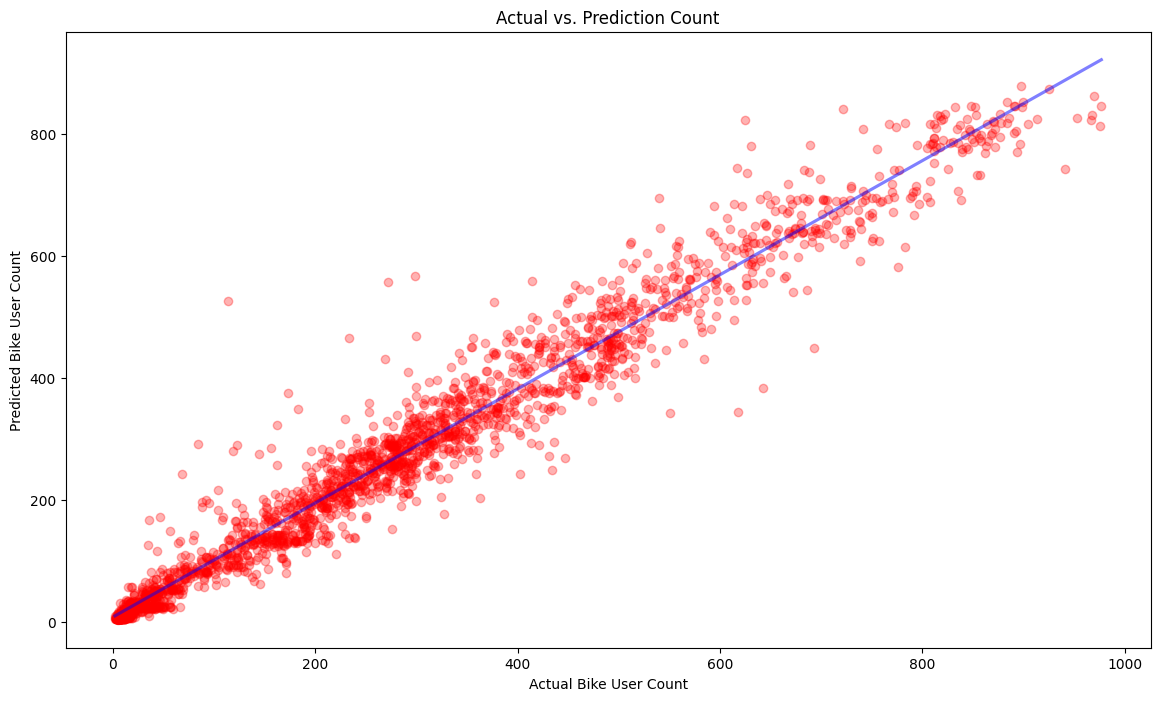

In [23]:
plt.figure(figsize=(14, 8))
sns.regplot(x=y_test, y=y_pred_xgb_tuning, ci=None, scatter_kws = {'color': 'red', 'alpha': 0.3}, line_kws = {'color': 'blue', 'alpha': 0.5}).set(title='Actual vs. Prediction Count', 
                                               xlabel='Actual Bike User Count', 
                                               ylabel='Predicted Bike User Count')
plt.show()

Terlihat adanya outlier pada hasil prediksi, di mana terdapat jumlah pengguna sepeda aktual yang rendah tetapi diprediksi jauh lebih tinggi atau overestimate dan juga sebaliknya atau underestimate. Kita dapat meneliti data-data apa saja yang termasuk ke dalam outlier ini dengan melihat grafik residual dan pengelompokan variabel target pada data test dengan rentang-rentang tertentu.

In [24]:
df_xgb = pd.DataFrame({
    'y_test' : y_test,
    'y_pred' : y_pred_xgb_tuning
})

df_xgb['residual'] = y_pred_xgb_tuning - y_test

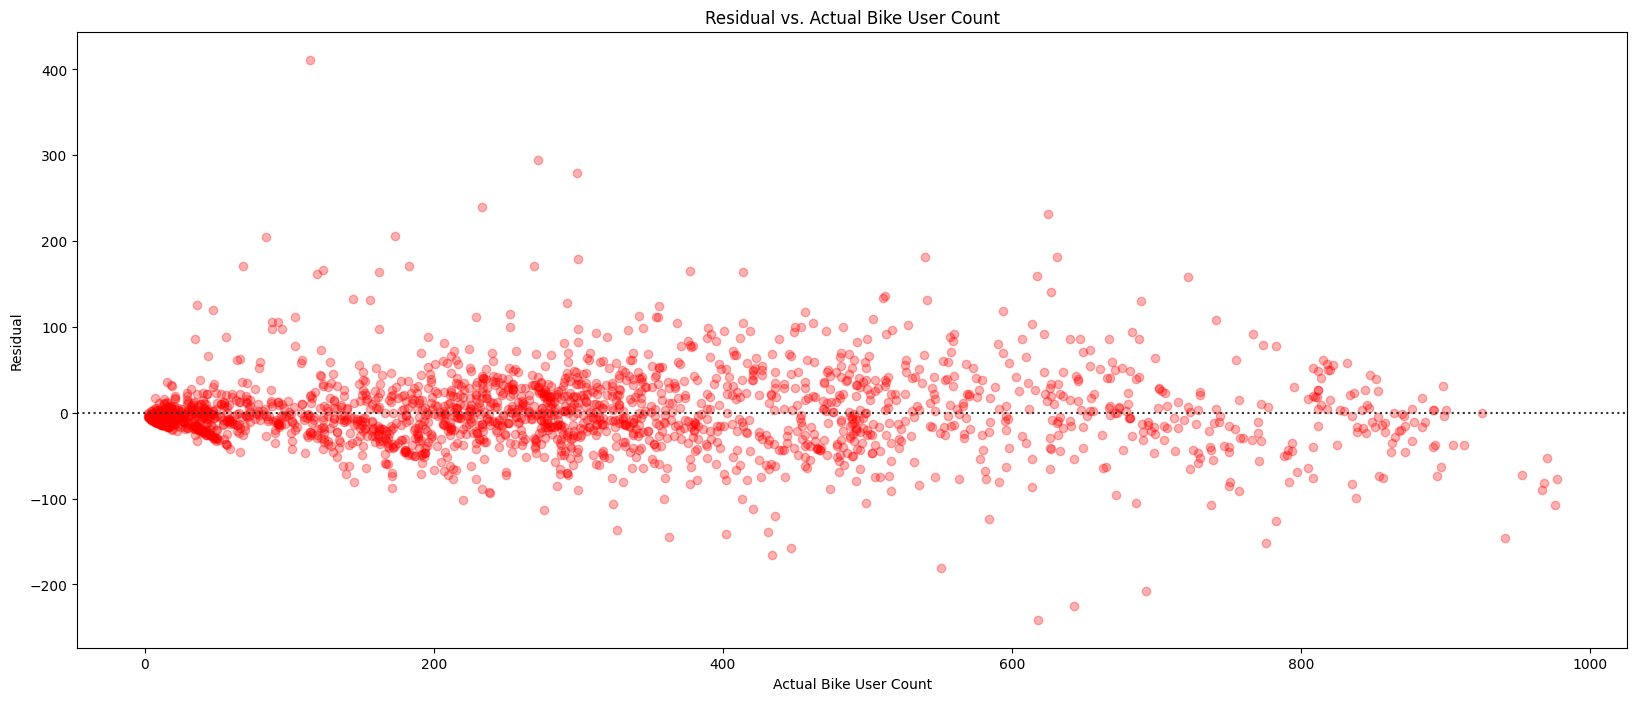

In [25]:
plt.figure(figsize=(20,8))
sns.residplot(x='y_test', y='residual', data=df_xgb, scatter_kws = {'color': 'red', 'alpha': 0.3}, line_kws = {'color': 'blue', 'alpha': 0.5}).set(title='Residual vs. Actual Bike User Count')
plt.xlabel('Actual Bike User Count')
plt.ylabel('Residual')
plt.show()

Dari grafik residual di atas, terlihat bahwa semakin besar nilai aktual jumlah pengguna sepeda, residualnya cenderung semakin menyebar dan bervariasi. Tetapi, pada rentang nilai aktual bike user count yang masih kecil pun (< 200) sudah terdapat outlier, yaitu yang sangat terlihat adalah adanya satu poin data dengan residual di sekitar 400.

In [26]:
tmp = X_test.loc[df_xgb[df_xgb['residual'] > 100].index]['count_lag_1']-y_test.loc[df_xgb[df_xgb['residual'] > 100].index]
tmp.values

array([-195,   95,  319,  405,  330,  204,  264,  118,  147,   -2,  116,
        153,   14,  212,  138,  153,  136,  516,  253,  249,   85,  164,
        218, -122,  -89,  208,  188,  523,  114,  398, -189,  107,  183,
        204,  206], dtype=int64)

In [27]:
tmp = X_test.loc[df_xgb[df_xgb['residual'] < -100].index]['count_lag_1']-y_test.loc[df_xgb[df_xgb['residual'] < -100].index]
tmp.values

array([-100, -154,  -48, -119,  -33,   92, -343,  -92,  -80, -273,   28,
       -220, -317,  159,   39,   74, -176,  -67, -282, -258,  -37,  -42,
        378,  176, -101, -439,  -42, -478, -127,  -34, -121, -201, -424,
       -254, -313, -119, -130,  -20, -172,  -97, -210, -434, -191,  -52,
       -196, -331, -129, -316,  -43, -252, -519,  -96, -206,  -32, -216,
       -249, -472, -306, -485], dtype=int64)

Ketika dilihat lebih lanjut, kebanyakan dari outlier tersebut mempunyai data jumlah pengguna di jam sebelumnya yang jauh lebih tinggi atau lebih rendah. Hal ini dapat terlihat dari kebanyakan selisih antara jumlah pengguna di jam sebelumnya dan saat ini pada data outlier tersebut bernilai di kisaran ratusan.

Sementara itu, jumlah pengguna sepeda di jam sebelumnya tadi kita tahu merupakan fitur paling berpengaruh terhadap variabel target. Kemungkinan yang terjadi adalah, ketika data bike user count di jam sebelumnya cukup tinggi, jumlah pengguna di jam selanjutnya akan terprediksi cukup tinggi juga sehingga ketika nilai aktualnya rendah, model akan overestimasi nilai prediksinya. Begitu pula sebaliknya.

In [28]:
dftarget = pd.DataFrame({'Actual Count': y_test, 'Predicted Count': y_pred_xgb_tuning})

df50 = dftarget[dftarget['Actual Count'] <=50]
df100 = dftarget[(dftarget['Actual Count']>50) & (dftarget['Actual Count']<=100)]
df150 = dftarget[(dftarget['Actual Count']>100) & (dftarget['Actual Count']<=150)]
df200 = dftarget[(dftarget['Actual Count']>150) & (dftarget['Actual Count']<=200)]
df250 = dftarget[(dftarget['Actual Count']>200) & (dftarget['Actual Count']<=250)]
df300 = dftarget[(dftarget['Actual Count']>250) & (dftarget['Actual Count']<=300)]
df350 = dftarget[(dftarget['Actual Count']>300) & (dftarget['Actual Count']<=350)]
df400 = dftarget[(dftarget['Actual Count']>350) & (dftarget['Actual Count']<=400)]
df450 = dftarget[(dftarget['Actual Count']>400) & (dftarget['Actual Count']<=450)]
df500 = dftarget[(dftarget['Actual Count']>450) & (dftarget['Actual Count']<=500)]
df550 = dftarget[(dftarget['Actual Count']>500) & (dftarget['Actual Count']<=550)]
df600 = dftarget[(dftarget['Actual Count']>550) & (dftarget['Actual Count']<=600)]
df600plus = dftarget[dftarget['Actual Count']>600]

target_range = [df50, df100, df150, df200, df250, df300, df350, df400, df450, df500, df550, df600, df600plus, dftarget]
index_range = ['<=50', '51-100', '101-150', '151-200', '201-250', '251-300', '301-350', '351-400', '401-450', '451-500', '501-550', '551-600', '>600', 'All Count Range (Max 953)']
mae = []
mape = []
n_data = []
for target in target_range:
    scoremae = mean_absolute_error(target['Actual Count'], target['Predicted Count'])
    scoremape = mean_absolute_percentage_error(target['Actual Count'], target['Predicted Count']) * 100
    mae.append(scoremae)
    mape.append(scoremape)
    n_data.append(len(target))

range_metrics = pd.DataFrame({
              "Score MAE": mae,
              "Score MAPE (%)": mape,
              "Jumlah Data": n_data}, index=index_range)
range_metrics

,Score MAE,Score MAPE (%),Jumlah Data
<=50,8.615829,44.972544,459
51-100,20.363032,28.428331,126
101-150,29.794786,24.061659,127
151-200,32.553884,18.611866,179
201-250,28.970427,12.881116,189
251-300,31.169880,11.161162,231
301-350,30.931248,9.496898,166
351-400,42.358541,11.378284,115
401-450,51.213542,12.067840,97
451-500,42.033947,8.809470,130


Tabel di atas merupakan pengelompokan metrik evaluasi hasil prediksi data test berdasarkan rentang nilai aktual jumlah pengguna sepeda. Terlihat bahwa nilai MAPE paling tinggi (44%) terjadi pada rentang jumlah pengguna sepeda aktual kurang dari 50 yang bisa dinyatakan sebagai limitasi model atau model belum dapat memprediksi target dengan baik di bawah batas tersebut. Jumlah pengguna sepeda aktual di atas 50 pengguna sudah dapat diprediksi dengan cukup baik oleh model.

## **4. Conclusion**

* Parameter terpilih yang terbaik dari hyperparameter tuninguntuk benchmark model Extra Gradient Boosting adalah:
    * max_depth = 4
    * learning_rate = 0.2
    * n_estimators = 180
    * colbysample_tree = 1 (100% atau semua kolom digunakan)
* Dari pemodelan yang sudah dilakukan, jumlah pengguna sepeda atau `count` dipengaruhi oleh `count_lag_1` atau jumlah pengguna sepeda pada jam sebelumnya, `hour` atau jam saat itu, `workingday` atau jenis hari merupakan hari kerja atau bukan, dan `dayofweek` atau hari dalam satu minggu (Senin, Selasa, dst)
* Metrik evaluasi yang digunakan pada model adalah nilai Mean Absolute Error dan Mean Absolute Percentage Error, atau rerata absolut dari selisih prediksi dengan nilai sebenarnya dan persentasenya. Setelah melakukan hyperparameter tuning pada model, nilai MAPE yang dihasilkan adalah sebesar ~20%. Dengan kata lain, jika model digunakan untuk memprediksi jumlah pengguna sepeda Capital Bikeshare pada rentang nilai seperti yang ada pada data train saat ini (maksimal 957 orang pengguna), perkiraan jumlah pengguna rata-rata akan meleset kurang lebih sebesar 20% dari jumlah yang seharusnya.
* Perlu dicatat bahwa model memiliki keterbatasan tidak bisa melakukan ekstrapolasi yaitu tidak bisa menghasilkan nilai prediksi lebih besar dari nilai maksimal target yang ada pada data train. Prediksi juga dapat meleset lebih jauh karena bias yang dihasilkan model masih cukup tinggi, seperti yang terlihat dari grafik antara bike user count aktual dan prediksi dan setelah diteliti lebih lanjut adalah akibat fitur jumlah pengguna sepeda di jam sebelumnya yang tinggi. Model cenderung overestimasi kondisi tersebut.

## **5. Recommendation**

* Melakukan eksplorasi fitur lebih lanjut: (1) untuk menangani overestimasi prediksi oleh model extra gradient boosting pada variabel target yang memiliki jumlah pengguna sepeda di jam sebelumnya yang cukup tinggi, (2) meningkatkan performa model berbasis linear regresi menggunakan model perantara non-linear ataupun fitur non-linear.
* Model yang sudah dibangun bisa digunakan untuk pemodelan lain ataupun lebih lanjut. Adanya penambahan fitur yang lebih detil yaitu jumlah pengguna sepeda per lokasi (baik stasiun keberangkatan maupun tujuan) dapat mensolusikan permasalahan yang lebih tepat yaitu perlunya rebalancing secara berkala di masing-masing stasiun. Permasalahan yang sebenarnya lebih sering terjadi adalah (1) kekosongan sepeda di suatu stasiun, yang berakibat pada pengguna yang ingin menyewa sepeda tidak bisa memulai perjalanan di stasiun tersebut, (2) ketersediaan penuh sepeda di suatu stasiun, yang berakibat pada pengguna yang sudah menyelesaikan perjalanan tidak bisa mengembalikan sepeda di stasiun tersebut dan harus melanjutkan perjalanan ke stasiun terdekat lain yang masih mempunyai slot kosong untuk mengembalikan sepeda. Jika kebutuhan sepeda per lokasi bisa diketahui terlebih dulu, perusahaan dapat menyusun strategi rebalancing dengan lebih baik. Akan tetapi, data yang saat ini digunakan mempunyai keterbatasan fitur sehingga baru bisa melakukan forecasting secara keseluruhan (bukan per masing-masing lokasi) setiap jamnya.

## **Save Model**

In [30]:
import pickle

pickle.dump(xgb_tuning, open('../data/model/capital_bikeshare_xgb.sav', 'wb'))

In [31]:
# Load model
filename = '../data/model/capital_bikeshare_xgb.sav'
loaded_model = pickle.load(open(filename, 'rb'))
print('MAE test data')
print(mean_absolute_error(y_test, loaded_model.predict(X_test)))

MAE test data
31.915108569938205
